
## Step 1: Setup and Imports


In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import cv2
import requests
from PIL import Image
from io import BytesIO
import time

import sys
import os

# Adjust the path to point to your project root
sys.path.append(os.path.abspath(".."))

from Pokemon_Core.dataset_builder import create_dataset


## Image Download + Cropping


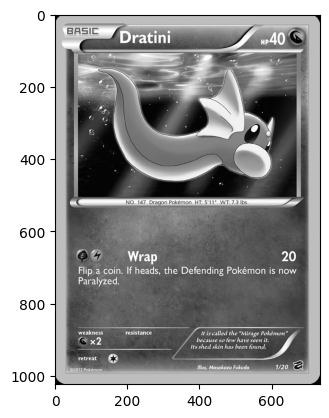

In [9]:
s_id = 'dv1'
p_id = '1'

# Get metadata and image URL from TCG API
url = f'https://api.pokemontcg.io/v2/cards/{s_id}-{p_id}'
response = requests.get(url).json()
image_url = response['data']['images']['large']

# Download and open the image
response_card = requests.get(image_url)
if response_card.status_code == 200:
    image = Image.open(BytesIO(response_card.content))
else:
    print(f"Failed to retrieve image. HTTP Status code: {response_card.status_code}")

# Convert to grayscale
grayImage = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
plt.imshow(grayImage, cmap='gray')

# Crop corners (percent-based approach)
width, height = image.size
bottomleft = image.crop((width * 0.75, height * 0.93, width, height))
bottomright = image.crop((0, height * 0.93, width * 0.25, height))


## Dataset Assembly (Set Looping + Labeling)

In [ ]:
setinfo = np.array([
    ['dv1', '21', 'Dragon Vault', 'right'],
    ['swsh9', '186', 'Brilliant Stars', 'left'],
    ['swsh45', '73', 'Shining Fates', 'left'],
    ['swsh6', '233', 'Chilling Reign', 'left'],
    ['swsh12pt5', '160', 'Crown Zenith', 'left'],
    ['xy1', '146', 'XY', 'right'],
    ['xy2', '110', 'Flashfire', 'right'],
    ['xy3', '114', 'Furious Fists', 'right'],
    ['g1', '117', 'Generations', 'right'],
    ['xy4', '124', 'Phantom Forces', 'right'],
    ['xy6', '112', 'Roaring Skies', 'right'],
    ['xy7', '100', 'Ancient Origins', 'right'],
    ['dp1', '130', 'Diamond & Pearl', 'right'],
    ['dp2', '124', 'Mysterious Treasures', 'right'],
    ['sm4', '126', 'Crimson Invasion', 'left'],
    ['swsh10', '216', 'Astral Radiance', 'left'],
    ['sv4', '266', 'Paradox Rift', 'left'],
    ['sv3pt5', '207', '151', 'left'],
    ['sv3', '230', 'Obsidian Flames', 'left'],
    ['sv2', '279', 'Paldea Evolved', 'left']
])

dataset_df = pd.DataFrame(columns=['corner', 'position', 'set_id', 'set_name'], index=[0])
k = 0









for j in range(setinfo.shape[0]):
    s_id = setinfo[j, 0]
    print(f'On-going set: {s_id}')

    for i in range(1, int(setinfo[j, 1]) + 1):
        card_id = f'{s_id}-{i}'
        url = f'https://api.pokemontcg.io/v2/cards/{card_id}'

        try:
            r = requests.get(url)
            if r.status_code != 200:
                print(f"❌ {card_id} - Status code: {r.status_code}")
                continue

            try:
                response = r.json()
            except Exception as e:
                print(f"⚠️ Failed to parse JSON for {card_id}: {e}")
                continue

            image_url = response['data']['images']['large']
            response_card = requests.get(image_url)

            if response_card.status_code == 200:
                image = Image.open(BytesIO(response_card.content))
                width, height = image.size

                bottomleft = image.crop((width * 0.75, height * 0.93, width, height))
                bottomright = image.crop((0, height * 0.93, width * 0.25, height))

                graybottomleft = cv2.cvtColor(np.array(bottomleft), cv2.COLOR_BGR2GRAY)
                graybottomright = cv2.cvtColor(np.array(bottomright), cv2.COLOR_BGR2GRAY)

                if setinfo[j, 3] == 'left':
                    dataset_df.loc[k] = [graybottomleft, 'left', setinfo[j, 0], setinfo[j, 2]]
                    k += 1
                    dataset_df.loc[k] = [graybottomright, 'right', 'no', 'no']
                    k += 1
                elif setinfo[j, 3] == 'right':
                    dataset_df.loc[k] = [graybottomleft, 'left', 'no', 'no']
                    k += 1
                    dataset_df.loc[k] = [graybottomright, 'right', setinfo[j, 0], setinfo[j, 2]]
                    k += 1
            else:
                print(f"⚠️ Failed to retrieve image for {card_id}. Status code: {response_card.status_code}")

        except Exception as e:
            print(f"🔥 Unexpected error with {card_id}: {e}")

        time.sleep(2)  # avoid overwhelming the server

















# for j in range(setinfo.shape[0]):
#     s_id = setinfo[j, 0]
#     print(f'On-going set: {s_id}')

#     for i in range(1, int(setinfo[j, 1]) + 1):
#         url = f'https://api.pokemontcg.io/v2/cards/{s_id}-{str(i)}'
#         response = requests.get(url).json()
#         image_url = response['data']['images']['large']
#         response_card = requests.get(image_url)

#         if response_card.status_code == 200:
#             image = Image.open(BytesIO(response_card.content))
#             width, height = image.size

#             bottomleft = image.crop((width * 0.75, height * 0.93, width, height))
#             bottomright = image.crop((0, height * 0.93, width * 0.25, height))

#             graybottomleft = cv2.cvtColor(np.array(bottomleft), cv2.COLOR_BGR2GRAY)
#             graybottomright = cv2.cvtColor(np.array(bottomright), cv2.COLOR_BGR2GRAY)

#             if setinfo[j, 3] == 'left':
#                 dataset_df.loc[k] = [graybottomleft, 'left', setinfo[j, 0], setinfo[j, 2]]
#                 k += 1
#                 dataset_df.loc[k] = [graybottomright, 'right', 'no', 'no']
#                 k += 1
#             elif setinfo[j, 3] == 'right':
#                 dataset_df.loc[k] = [graybottomleft, 'left', 'no', 'no']
#                 k += 1
#                 dataset_df.loc[k] = [graybottomright, 'right', setinfo[j, 0], setinfo[j, 2]]
#                 k += 1
#         else:
#             print(f"Failed to retrieve image. HTTP Status code: {response_card.status_code}")

On-going set: dv1
On-going set: swsh9
❌ swsh9-162 - Status code: 404
❌ swsh9-163 - Status code: 404
❌ swsh9-164 - Status code: 404
❌ swsh9-165 - Status code: 404
❌ swsh9-166 - Status code: 404
On-going set: swsh45
On-going set: swsh6
On-going set: swsh12pt5
On-going set: xy1
On-going set: xy2
❌ xy2-110 - Status code: 404
On-going set: xy3
❌ xy3-114 - Status code: 404
On-going set: g1
❌ g1-84 - Status code: 404
❌ g1-85 - Status code: 404
❌ g1-86 - Status code: 404
❌ g1-87 - Status code: 404
❌ g1-88 - Status code: 404
❌ g1-89 - Status code: 404
❌ g1-90 - Status code: 404
❌ g1-91 - Status code: 404
❌ g1-92 - Status code: 404
❌ g1-93 - Status code: 404
❌ g1-94 - Status code: 404
❌ g1-95 - Status code: 404
❌ g1-96 - Status code: 404
❌ g1-97 - Status code: 404
❌ g1-98 - Status code: 404
❌ g1-99 - Status code: 404
❌ g1-100 - Status code: 404
❌ g1-101 - Status code: 404
❌ g1-102 - Status code: 404
❌ g1-103 - Status code: 404
❌ g1-104 - Status code: 404
❌ g1-105 - Status code: 404
❌ g1-106 - St

In [12]:
dataset_df.head()

,corner,position,set_id,set_name
0,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
1,"[[190, 190, 190, 190, 190, 190, 190, 190, 190,...",right,dv1,Dragon Vault
2,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no
3,"[[190, 190, 190, 190, 190, 190, 190, 190, 190,...",right,dv1,Dragon Vault
4,"[[85, 80, 80, 80, 80, 79, 79, 79, 79, 68, 68, ...",left,no,no


In [ ]:
import pandas as pd

df = pd.read_csv("../Data/External/Set_Symbols/pokemon_tcg_sets.csv")
df.head()

,Set Name,Description,Series,Release Date,Printed Total,Total,Online Code,Symbol Image Path
0,Jungle,"Introduced in 1999, Jungle continued the TCG's...",Base,Released: June 1999,64,64,JU,/home/moondeep/code/Pavel151515/Pokemon_Card_P...
1,Fossil,"Released in 1999, Fossil expanded the card poo...",Base,Released: October 1999,62,62,FO,/home/moondeep/code/Pavel151515/Pokemon_Card_P...
2,Team Rocket,Introduces darker themes with Team Rocket's in...,Base,Released: April 2000,82,83,TR,/home/moondeep/code/Pavel151515/Pokemon_Card_P...
3,Southern Islands,A special promotional set featuring postcards ...,Other,Released: July 2001,18,18,NaN,/home/moondeep/code/Pavel151515/Pokemon_Card_P...
4,Legendary Treasures,The eleventh and final set to be released in t...,Black & White,Released: November 2013,113,140,LTR,/home/moondeep/code/Pavel151515/Pokemon_Card_P...
5,Scarlet & Violet,The first set to be released in the Scarlet & ...,Scarlet & Violet,Released: March 2023,198,258,SVI,/home/moondeep/code/Pavel151515/Pokemon_Card_P...
